In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from dotenv import load_dotenv
from sklearn.calibration import calibration_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, make_scorer, precision_recall_fscore_support, precision_score, recall_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_val_score, train_test_split

load_dotenv()

True

In [2]:
# configuration
RANDOM_STATE = int(os.environ.get("RANDOM_STATE"))
UNCERTAIN_AS_1 = True  # how to handle UNSURE responses: True -> 1, False -> 0.5
RESULTS_DIR = os.environ.get("RESULTS_DIR")

# plotting style
plt.style.use("default")
sns.set_palette("husl")

# 1. Data Import and Preparation

In [3]:
# import original dataset with labels
original_df = pd.read_csv("../data/full_dataset.csv")[["id", "MK_IN"]]
original_df = original_df.rename(columns={"id": "paper_id", "MK_IN": "label"})
original_df.head(5)

,paper_id,label
0,0,False
1,1,True
2,2,True
3,3,True
4,4,False


In [4]:
# import LLM responses df
llm_responses_df = pd.read_csv("../results/5/emanuele/llm_responses.csv")

# convert it to wide format
llm_responses_df_wide = llm_responses_df.pivot(index="paper_id", columns="question_id", values="response").reset_index()
llm_responses_df_wide

question_id,paper_id,E1,E10,E11,E12,E2,E3,E4,E5,E6,...,I16,I17,I2,I3,I4,I5,I6,I7,I8,I9
0,0,NO,UNSURE,NO,NO,NO,NO,NO,YES,YES,...,NO,NO,NO,YES,UNSURE,NO,UNSURE,UNSURE,NO,UNSURE
1,1,NO,NO,NO,NO,NO,NO,NO,NO,NO,...,YES,YES,NO,YES,YES,YES,YES,UNSURE,UNSURE,YES
2,2,NO,NO,NO,NO,NO,NO,NO,NO,NO,...,NO,YES,NO,YES,YES,YES,YES,NO,NO,UNSURE
3,3,NO,NO,NO,NO,NO,NO,NO,NO,NO,...,NO,YES,NO,YES,YES,NO,NO,NO,NO,UNSURE
4,4,NO,NO,NO,NO,YES,NO,NO,NO,YES,...,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5742,5742,NO,NO,NO,NO,NO,NO,NO,NO,NO,...,NO,NO,NO,YES,NO,NO,NO,NO,NO,NO
5743,5743,NO,NO,NO,NO,NO,NO,NO,NO,NO,...,NO,NO,NO,YES,NO,NO,NO,NO,NO,NO
5744,5744,NO,NO,NO,NO,NO,NO,NO,NO,NO,...,NO,NO,NO,YES,NO,NO,NO,NO,NO,UNSURE
5745,5745,NO,NO,NO,NO,NO,NO,NO,NO,NO,...,NO,NO,NO,YES,NO,NO,NO,NO,NO,NO


In [5]:
# merge
df = pd.merge(original_df, llm_responses_df_wide, on="paper_id", how="inner")
df

,paper_id,label,E1,E10,E11,E12,E2,E3,E4,E5,...,I16,I17,I2,I3,I4,I5,I6,I7,I8,I9
0,0,False,NO,UNSURE,NO,NO,NO,NO,NO,YES,...,NO,NO,NO,YES,UNSURE,NO,UNSURE,UNSURE,NO,UNSURE
1,1,True,NO,NO,NO,NO,NO,NO,NO,NO,...,YES,YES,NO,YES,YES,YES,YES,UNSURE,UNSURE,YES
2,2,True,NO,NO,NO,NO,NO,NO,NO,NO,...,NO,YES,NO,YES,YES,YES,YES,NO,NO,UNSURE
3,3,True,NO,NO,NO,NO,NO,NO,NO,NO,...,NO,YES,NO,YES,YES,NO,NO,NO,NO,UNSURE
4,4,False,NO,NO,NO,NO,YES,NO,NO,NO,...,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5742,5742,False,NO,NO,NO,NO,NO,NO,NO,NO,...,NO,NO,NO,YES,NO,NO,NO,NO,NO,NO
5743,5743,False,NO,NO,NO,NO,NO,NO,NO,NO,...,NO,NO,NO,YES,NO,NO,NO,NO,NO,NO
5744,5744,False,NO,NO,NO,NO,NO,NO,NO,NO,...,NO,NO,NO,YES,NO,NO,NO,NO,NO,UNSURE
5745,5745,False,NO,NO,NO,NO,NO,NO,NO,NO,...,NO,NO,NO,YES,NO,NO,NO,NO,NO,NO


## Feature and Label Extraction

In [6]:
features_cols = [col for col in df.columns if col.startswith("I") or col.startswith("E")]
print(f"Number of features: {len(features_cols)}")
print(f"Features: {features_cols}")
label_col = "label"

Number of features: 29
Features: ['E1', 'E10', 'E11', 'E12', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'I1', 'I10', 'I11', 'I12', 'I13', 'I14', 'I15', 'I16', 'I17', 'I2', 'I3', 'I4', 'I5', 'I6', 'I7', 'I8', 'I9']


In [7]:
# Helper function to convert YES/NO/UNSURE to numeric
def convert_yes_no_unsure_to_int(value: str, unsure_as_1: bool) -> int:
    """Convert Yes/No/Unsure to binary: NO->0, YES->1, UNSURE->1 or 0.5"""
    if value == "NO":
        return 0
    elif value == "YES":
        return 1
    elif value == "UNSURE":
        return 1 if unsure_as_1 else 0.5
    else:
        raise ValueError(f"Unexpected value: {value}")


# Convert features for analysis
df_temp = df.copy()
for col in features_cols:
    df_temp[col] = df_temp[col].apply(convert_yes_no_unsure_to_int, unsure_as_1=UNCERTAIN_AS_1)


df_temp.head(5)

,paper_id,label,E1,E10,E11,E12,E2,E3,E4,E5,...,I16,I17,I2,I3,I4,I5,I6,I7,I8,I9
0,0,False,0,1,0,0,0,0,0,1,...,0,0,0,1,1,0,1,1,0,1
1,1,True,0,0,0,0,0,0,0,0,...,1,1,0,1,1,1,1,1,1,1
2,2,True,0,0,0,0,0,0,0,0,...,0,1,0,1,1,1,1,0,0,1
3,3,True,0,0,0,0,0,0,0,0,...,0,1,0,1,1,0,0,0,0,1
4,4,False,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# 2. Data Quality Analysis

## Data Consistency Check

Identify papers with identical features but different labels.

In [8]:
duplicates = df_temp.groupby(features_cols).filter(lambda x: len(x) > 1 and x["label"].nunique() > 1)

if len(duplicates) > 0:
    print(f"Found {len(duplicates)}/{len(df_temp)} ({len(duplicates)/len(df_temp):.2%}) papers with identical features but different labels")
    duplicates_sorted = duplicates[["paper_id", "label"] + features_cols].sort_values(by=features_cols)
    display(duplicates_sorted)
else:
    print("No papers with identical features but different labels found")

Found 1489/5747 (25.91%) papers with identical features but different labels


,paper_id,label,E1,E10,E11,E12,E2,E3,E4,E5,...,I16,I17,I2,I3,I4,I5,I6,I7,I8,I9
9,9,False,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
13,13,False,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
32,32,False,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
85,85,False,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
92,92,False,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4844,4844,False,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
5000,5000,False,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
5393,5393,False,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
5436,5436,True,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


## Feature Correlation Analysis

Check if I-features (inclusion) correlate positively and E-features (exclusion) correlate negatively with the label.

In [9]:
# Calculate correlations
correlation_with_label = df_temp[features_cols + ["label"]].corr()["label"].drop("label").sort_values()
correlation_with_label

E6    -0.248381
E2    -0.110895
E5    -0.074382
E8    -0.043397
E1    -0.024443
E3    -0.004272
E7     0.000237
E11    0.001592
E9     0.005401
E10    0.013151
E12    0.045110
I11    0.045269
E4     0.048082
I12    0.068052
I2     0.081814
I10    0.088892
I15    0.098212
I8     0.117641
I6     0.136609
I16    0.150488
I7     0.151823
I14    0.201224
I5     0.237006
I17    0.253671
I9     0.273187
I13    0.281975
I3     0.312726
I4     0.313898
I1     0.353426
Name: label, dtype: float64

In [10]:
# export for thesis
correlation_with_label.to_csv(f"../results/thesis_figures_tables_generation/5/feature_correlation_with_label.csv", index=True)

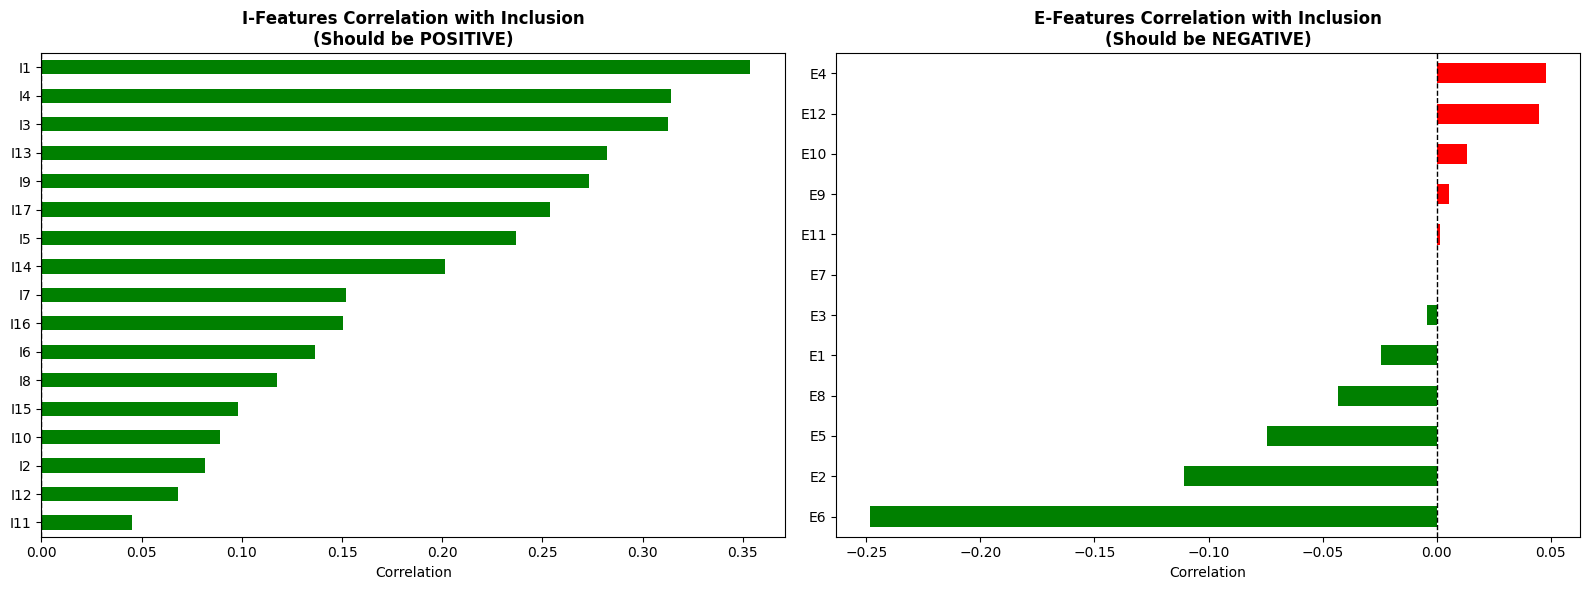


6 E-features have POSITIVE correlation:
E4     0.048
E12    0.045
E10    0.013
E9     0.005
E11    0.002
E7     0.000
Name: label, dtype: float64


In [11]:
i_features_corr = correlation_with_label[[col for col in correlation_with_label.index if col.startswith("I")]]
e_features_corr = correlation_with_label[[col for col in correlation_with_label.index if col.startswith("E")]]

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

i_features_corr.sort_values().plot(kind="barh", ax=axes[0], color=["red" if x < 0 else "green" for x in i_features_corr.sort_values()])
axes[0].set_title("I-Features Correlation with Inclusion\n(Should be POSITIVE)", fontweight="bold")
axes[0].axvline(0, color="black", linestyle="--", linewidth=1)
axes[0].set_xlabel("Correlation")

e_features_corr.sort_values().plot(kind="barh", ax=axes[1], color=["green" if x < 0 else "red" for x in e_features_corr.sort_values()])
axes[1].set_title("E-Features Correlation with Inclusion\n(Should be NEGATIVE)", fontweight="bold")
axes[1].axvline(0, color="black", linestyle="--", linewidth=1)
axes[1].set_xlabel("Correlation")

plt.tight_layout()
plt.show()

# Identify problematic features
problematic_i = i_features_corr[i_features_corr < 0]
problematic_e = e_features_corr[e_features_corr > 0]

if len(problematic_i) > 0:
    print(f"{len(problematic_i)} I-features have NEGATIVE correlation:")
    print(problematic_i.round(3))

if len(problematic_e) > 0:
    print(f"\n{len(problematic_e)} E-features have POSITIVE correlation:")
    print(problematic_e.round(3).sort_values(ascending=False))

# Store problematic E-features for later filtering
problematic_e_features = problematic_e.index.tolist()

## LLM Response Quality: UNSURE Rates

In [12]:
UNSURE_RATE_MAX = 15 # maximum percentage of UNSURE responses allowed per feature

In [13]:
# Analyze UNSURE responses to identify confusing features
unsure_counts = {}
for col in features_cols:
    unsure_pct = (df[col] == "UNSURE").sum() / len(df) * 100
    unsure_counts[col] = unsure_pct

unsure_df = pd.DataFrame(list(unsure_counts.items()), columns=["Feature", "Unsure %"]).sort_values("Unsure %", ascending=False)

print("Features with high UNSURE rates (potential LLM confusion):")
display(unsure_df.round(1))

# Identify features with UNSURE_RATE_MAX% UNSURE responses
high_unsure_features = unsure_df[unsure_df["Unsure %"] > UNSURE_RATE_MAX]["Feature"].tolist()
if len(high_unsure_features) > 0:
    print(f"{len(high_unsure_features)} features have >{UNSURE_RATE_MAX}% UNSURE responses:")
    print(high_unsure_features)

Features with high UNSURE rates (potential LLM confusion):


,Feature,Unsure %
28,I9,39.9
17,I14,32.1
25,I6,25.3
26,I7,17.7
24,I5,11.1
23,I4,10.8
16,I13,9.5
27,I8,7.8
12,I1,3.8
7,E5,3.5


4 features have >15% UNSURE responses:
['I9', 'I14', 'I6', 'I7']


# 3. Data Preprocessing

In [14]:
df_processed = df.copy()

# Convert feature columns to numeric
for col in features_cols:
    df_processed[col] = df_processed[col].apply(convert_yes_no_unsure_to_int, unsure_as_1=UNCERTAIN_AS_1)

# Prepare X (features) and y (labels)
X = df_processed[features_cols]
y = df_processed[label_col]

print(f"Dataset shape: {X.shape}")
print(f"\nClass distribution:")
print(y.value_counts(normalize=True).round(2))

Dataset shape: (5747, 29)

Class distribution:
label
False    0.91
True     0.09
Name: proportion, dtype: float64


In [15]:
print(df_processed.head(5))

   paper_id  label  E1  E10  E11  E12  E2  E3  E4  E5  ...  I16  I17  I2  I3  \
0         0  False   0    1    0    0   0   0   0   1  ...    0    0   0   1   
1         1   True   0    0    0    0   0   0   0   0  ...    1    1   0   1   
2         2   True   0    0    0    0   0   0   0   0  ...    0    1   0   1   
3         3   True   0    0    0    0   0   0   0   0  ...    0    1   0   1   
4         4  False   0    0    0    0   1   0   0   0  ...    0    0   0   0   

   I4  I5  I6  I7  I8  I9  
0   1   0   1   1   0   1  
1   1   1   1   1   1   1  
2   1   1   1   0   0   1  
3   1   0   0   0   0   1  
4   0   0   0   0   0   0  

[5 rows x 31 columns]


In [16]:
# Train/Validation/Test split: 60% / 20% / 20%
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=RANDOM_STATE, stratify=y_train_full)

print(f"Train: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"Val:   {len(X_val)} ({len(X_val)/len(X)*100:.1f}%)")
print(f"Test:  {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")

Train: 3447 (60.0%)
Val:   1150 (20.0%)
Test:  1150 (20.0%)


# 4. Model Training

In [17]:
# Initial Random Forest with default hyperparameters
rf_classifier = RandomForestClassifier(
    n_estimators=500,
    random_state=RANDOM_STATE,
    class_weight="balanced",  # Handle class imbalance
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    n_jobs=-1,
)

rf_classifier.fit(X_train, y_train)

,n_estimators,500
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [18]:
# helper function for specificity calculation
def specificity_score(y_true, y_pred):
    """Calculate specificity (True Negative Rate)"""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)


specificity_scorer = make_scorer(specificity_score)

In [19]:
# Cross-validation setup
N_FOLDS = 5
cv = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)

In [20]:
# cross-validation with different scoring metrics
cv_scores_accuracy = cross_val_score(rf_classifier, X_train, y_train, cv=cv, scoring="accuracy")
cv_scores_precision = cross_val_score(rf_classifier, X_train, y_train, cv=cv, scoring="precision")
cv_scores_recall = cross_val_score(rf_classifier, X_train, y_train, cv=cv, scoring="recall")
cv_scores_specificity = cross_val_score(rf_classifier, X_train, y_train, cv=cv, scoring=specificity_scorer)

In [21]:
# Evaluate with cross-validation
cv_scores_accuracy = cross_val_score(rf_classifier, X_train, y_train, cv=cv, scoring="accuracy")
cv_scores_precision = cross_val_score(rf_classifier, X_train, y_train, cv=cv, scoring="precision")
cv_scores_recall = cross_val_score(rf_classifier, X_train, y_train, cv=cv, scoring="recall")
cv_scores_specificity = cross_val_score(rf_classifier, X_train, y_train, cv=cv, scoring=specificity_scorer)

train_metrics_df = (
    pd.DataFrame(
        {
            "metric": ["accuracy", "precision", "recall", "specificity"],
            f"mean over {N_FOLDS} folds": [
                cv_scores_accuracy.mean(),
                cv_scores_precision.mean(),
                cv_scores_recall.mean(),
                cv_scores_specificity.mean(),
            ],
        }
    )
    .set_index("metric")
    .round(2)
)

print("CROSS-VALIDATION RESULTS (Train Set)")
display(train_metrics_df)

CROSS-VALIDATION RESULTS (Train Set)


,mean over 5 folds
metric,
accuracy,0.96
precision,0.74
recall,0.79
specificity,0.97


## Initial Test Set Evaluation

In [22]:
y_pred = rf_classifier.predict(X_test)
y_pred_proba = rf_classifier.predict_proba(X_test)

test_accuracy = accuracy_score(y_test, y_pred)
precision, recall, _, _ = precision_recall_fscore_support(y_test, y_pred, average="binary")
test_specificity = specificity_score(y_test, y_pred)

test_metrics_df = (
    pd.DataFrame(
        {
            "metric": ["accuracy", "precision", "recall", "specificity"],
            "test set": [test_accuracy, precision, recall, test_specificity],
        }
    )
    .set_index("metric")
    .round(2)
)

print("TEST SET RESULTS (Default Classifier)")
display(test_metrics_df)

TEST SET RESULTS (Default Classifier)


,test set
metric,
accuracy,0.95
precision,0.72
recall,0.81
specificity,0.97


In [23]:
# Feature importance
feature_importance = (
    pd.DataFrame(
        {
            "feature": features_cols,
            "importance": rf_classifier.feature_importances_,
        }
    )
    .sort_values("importance", ascending=False)
    .set_index("feature")
    .round(2)
)

print("Top 5 Most Important Features:")
display(feature_importance.head(5))

print(f"Top 5 features account for {feature_importance.head(5)['importance'].sum():.1%} of total importance")
print(f"Top 10 features account for {feature_importance.head(10)['importance'].sum():.1%} of total importance")

Top 5 Most Important Features:


,importance
feature,
I1,0.20
I4,0.15
I3,0.14
I13,0.10
E6,0.07


Top 5 features account for 66.0% of total importance
Top 10 features account for 83.0% of total importance


# 5. Hyperparameter Tuning

## Grid Search

In [24]:
param_grid = {
    "n_estimators": [100, 200, 500],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 4],
    "min_samples_leaf": [2, 3],
    "bootstrap": [True, False],
}

scoring = {
    "accuracy": "accuracy",
    "precision": "precision",
    "recall": "recall",
    "specificity": specificity_scorer,
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=RANDOM_STATE, class_weight="balanced", n_jobs=-1),
    param_grid=param_grid,
    cv=cv,
    scoring=scoring,
    refit="recall",  # Optimize for recall
    n_jobs=-1,
    verbose=1,
)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best CV Recall Score:", round(grid_search.best_score_, 3))

best_rf_gs = grid_search.best_estimator_

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Parameters: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 200}
Best CV Recall Score: 0.934


In [ ]:
from sklearn.metrics import confusion_matrix

y_pred_gs = best_rf_gs.predict(X_test)
precision_gs, recall_gs, _, _ = precision_recall_fscore_support(y_test, y_pred_gs, average="binary")

tn, fp, fn, tp = confusion_matrix(y_test, y_pred_gs).ravel()
specificity_gs = tn / (tn + fp)

print(f"Grid Search - Test Set: Precision = {precision_gs:.2f}, Recall = {recall_gs:.2f}, Specificity = {specificity_gs:.2f}")

Grid Search - Test Set: Precision = 0.62, Recall = 0.91, Specificity = 0.94


## Randomized Search

In [26]:
param_distributions = {
    "n_estimators": [100, 200, 350, 500],
    "max_depth": [None, 5, 10, 15, 20],
    "min_samples_split": [2, 3, 4],
    "min_samples_leaf": [2, 3, 4, 5],
    "bootstrap": [True, False],
}

random_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=RANDOM_STATE, class_weight="balanced", n_jobs=-1),
    param_distributions=param_distributions,
    n_iter=40,
    cv=cv,
    scoring=scoring,
    refit="recall",
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=1,
)
random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)
print("Best CV Recall Score:", round(random_search.best_score_, 3))

best_rf_rnd = random_search.best_estimator_

Fitting 5 folds for each of 40 candidates, totalling 200 fits


/opt/homebrew/Cellar/python@3.12/3.12.9/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/opt/homebrew/Cellar/python@3.12/3.12.9/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/opt/homebrew/Cellar/python@3.12/3.12.9/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See http

Best Parameters: {'n_estimators': 100, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_depth': None, 'bootstrap': False}
Best CV Recall Score: 0.937


In [ ]:
y_pred_rnd = best_rf_rnd.predict(X_test)
precision_rnd, recall_rnd, _, _ = precision_recall_fscore_support(y_test, y_pred_rnd, average="binary")

tn, fp, fn, tp = confusion_matrix(y_test, y_pred_rnd).ravel()
specificity_rnd = tn / (tn + fp)

print(f"Random Search - Test Set: Precision = {precision_rnd:.2f}, Recall = {recall_rnd:.2f}, Specificity = {specificity_rnd:.2f}")

Random Search - Test Set: Precision = 0.61, Recall = 0.92, Specificity = 0.94


# 6. Threshold Tuning for 95%+ Recall

In [143]:
# Use best model from randomized search
classifier = best_rf_rnd
print(classifier)

RandomForestClassifier(bootstrap=False, class_weight='balanced',
                       min_samples_leaf=4, min_samples_split=3, n_jobs=-1,
                       random_state=42)


In [144]:
# Tune threshold on validation set to achieve 95%+ recall
y_val_proba = classifier.predict_proba(X_val)[:, 1]
thresholds = np.arange(0.05, 0.55, 0.05)

recall_threshold_results = []
for threshold in thresholds:
    y_val_pred = (y_val_proba >= threshold).astype(int)

    accuracy_thresh = accuracy_score(y_val, y_val_pred)
    precision_thresh, recall_thresh, _, _ = precision_recall_fscore_support(y_val, y_val_pred, average="binary")
    specificity_thresh = specificity_score(y_val, y_val_pred)

    recall_threshold_results.append(
        {
            "threshold": threshold,
            "recall": recall_thresh,
            "specificity": specificity_thresh,
            "accuracy": accuracy_thresh,
            "precision": precision_thresh,
        }
    )

recall_threshold_df = pd.DataFrame(recall_threshold_results).set_index("threshold")
recall_threshold_df.index = recall_threshold_df.index.round(3)
recall_threshold_df = recall_threshold_df.round(3)
recall_threshold_df

,recall,specificity,accuracy,precision
threshold,,,,
0.05,0.991,0.588,0.625,0.198
0.10,0.991,0.809,0.826,0.348
0.15,0.991,0.861,0.873,0.422
0.20,0.991,0.906,0.914,0.520
0.25,0.991,0.925,0.931,0.576
0.30,0.991,0.933,0.938,0.602
0.35,0.991,0.939,0.943,0.624
0.40,0.991,0.947,0.951,0.658
0.45,0.991,0.953,0.957,0.684


In [145]:
# export for thesis
recall_threshold_df.to_csv(f"../results/thesis_figures_tables_generation/5/recall_thresholds.csv", index=False)


In [146]:
# Find threshold achieving 95%+ recall with best precision
recall_95_thresholds = recall_threshold_df[recall_threshold_df["recall"] >= 0.95]
if len(recall_95_thresholds) > 0:
    best_threshold_95 = recall_95_thresholds["precision"].idxmax()
    print(f"Selected threshold: {best_threshold_95:.2f}")
    print(f"Validation recall: {recall_95_thresholds.loc[best_threshold_95, 'recall']:.1%}")
    print(f"Validation precision: {recall_95_thresholds.loc[best_threshold_95, 'precision']:.1%}")
else:
    best_threshold_95 = recall_threshold_df["recall"].idxmax()
    print(f"\nNo threshold achieves 95% recall. Using threshold with highest recall: {best_threshold_95:.2f}")

Selected threshold: 0.50
Validation recall: 95.3%
Validation precision: 68.9%


In [147]:
# Find threshold achieving 95%+ recall with best specificity
recall_95_thresholds = recall_threshold_df[recall_threshold_df["recall"] >= 0.95]
if len(recall_95_thresholds) > 0:
    best_threshold_95 = recall_95_thresholds["specificity"].idxmax()
    print(f"Selected threshold: {best_threshold_95:.2f}")
    print(f"Validation recall: {recall_95_thresholds.loc[best_threshold_95, 'recall']:.1%}")
    print(f"Validation specificity: {recall_95_thresholds.loc[best_threshold_95, 'specificity']:.1%}")
else:
    best_threshold_95 = recall_threshold_df["recall"].idxmax()
    print(f"\nNo threshold achieves 95% recall. Using threshold with highest recall: {best_threshold_95:.2f}")

Selected threshold: 0.50
Validation recall: 95.3%
Validation specificity: 95.6%


In [148]:
best_threshold_95 = 0.5

In [149]:
# Final evaluation on test set with chosen threshold
y_test_proba = classifier.predict_proba(X_test)[:, 1]
y_test_pred_final = (y_test_proba >= best_threshold_95).astype(int)

final_recall = recall_score(y_test, y_test_pred_final)
final_precision = precision_score(y_test, y_test_pred_final)
final_accuracy = accuracy_score(y_test, y_test_pred_final)
final_specificity = specificity_score(y_test, y_test_pred_final)

print(f"FINAL TEST SET EVALUATION (threshold={best_threshold_95:.2f}):")
print(f"Recall:      {final_recall:.1%}")
print(f"Precision:   {final_precision:.1%}")
print(f"Accuracy:    {final_accuracy:.1%}")
print(f"Specificity: {final_specificity:.1%}")

workload_reduction = 1 - (y_test_pred_final.sum() / len(y_test))
print(f"\nWorkload Reduction: {workload_reduction:.1%}")
print(f"Papers to review: {y_test_pred_final.sum()} out of {len(y_test)}")

FINAL TEST SET EVALUATION (threshold=0.50):
Recall:      91.5%
Precision:   60.6%
Accuracy:    93.7%
Specificity: 94.0%

Workload Reduction: 86.1%
Papers to review: 160 out of 1150


In [150]:
# export for thesis
y_test_pred_final_df = pd.DataFrame({
    "paper_id": X_test.index,
    "true_label": y_test,
    "predicted_label": y_test_pred_final,
    "predicted_proba": y_test_proba
})
y_test_pred_final_df.to_csv(f"../results/thesis_figures_tables_generation/5/llm_rf_test_set_predictions.csv", index=False)

Confusion Matrix:
                Predicted Negative  Predicted Positive
Actual Negative              981                  63
Actual Positive                9                  97



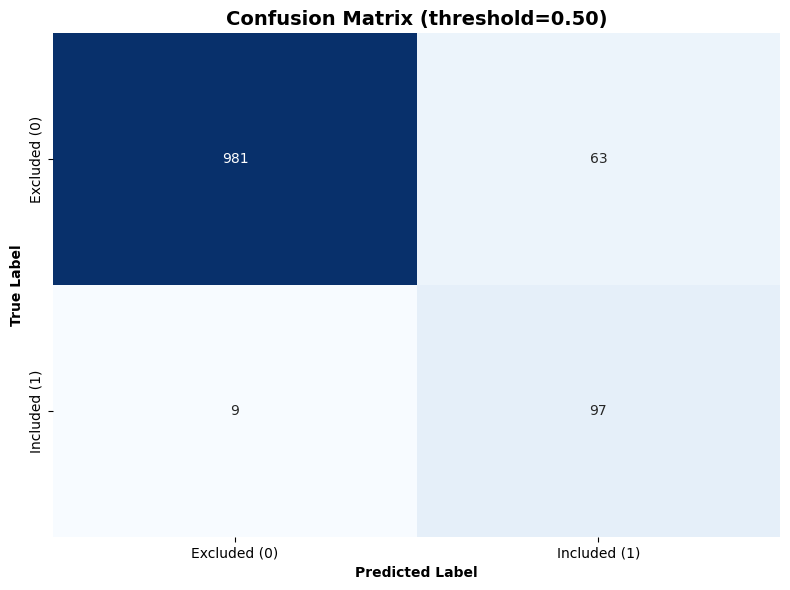


False Negatives: 9
These are papers that are actually INCLUDED but were predicted as EXCLUDED
False Negative Rate: 8.5% (this is 1 - Recall)

Top 10 False Negatives (ordered by decreasing probability):
(These were closest to being correctly classified)

  1. Paper ID: 1304, Probability: 0.420
  2. Paper ID: 2844, Probability: 0.399
  3. Paper ID: 1012, Probability: 0.255
  4. Paper ID: 30, Probability: 0.145
  5. Paper ID: 4414, Probability: 0.125
  6. Paper ID: 176, Probability: 0.072
  7. Paper ID: 2882, Probability: 0.053
  8. Paper ID: 1123, Probability: 0.031
  9. Paper ID: 3124, Probability: 0.023


In [151]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_test_pred_final)
tn, fp, fn, tp = cm.ravel()

print("Confusion Matrix:")
print(f"{'':>15} Predicted Negative  Predicted Positive")
print(f"Actual Negative {tn:>16}  {fp:>18}")
print(f"Actual Positive {fn:>16}  {tp:>18}")
print()

# Visualize confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False,
    xticklabels=["Excluded (0)", "Included (1)"],
    yticklabels=["Excluded (0)", "Included (1)"],
    ax=ax,
)
ax.set_xlabel("Predicted Label", fontweight="bold")
ax.set_ylabel("True Label", fontweight="bold")
ax.set_title(f"Confusion Matrix (threshold={best_threshold_95:.2f})", fontweight="bold", fontsize=14)
plt.tight_layout()
plt.show()

# Print false negatives (papers incorrectly classified as excluded)
print(f"\nFalse Negatives: {fn}")
print(f"These are papers that are actually INCLUDED but were predicted as EXCLUDED")
print(f"False Negative Rate: {fn / (tp + fn):.1%} (this is 1 - Recall)")
print()

# Get the indices of false negatives and their probabilities
fn_mask = (y_test == True) & (y_test_pred_final == 0)
fn_indices = y_test[fn_mask].index

if len(fn_indices) > 0:
    # Build a dataframe with paper_id and probability for false negatives
    fn_data = []
    for paper_idx in fn_indices:
        paper_id = df_processed.loc[paper_idx, "paper_id"]
        prob = y_test_proba[y_test.index.get_loc(paper_idx)]
        fn_data.append({"paper_idx": paper_idx, "paper_id": paper_id, "probability": prob})

    fn_df = pd.DataFrame(fn_data).sort_values("probability", ascending=False)

    print(f"Top 10 False Negatives (ordered by decreasing probability):")
    print("(These were closest to being correctly classified)")
    print()
    for i, row in enumerate(fn_df.head(10).itertuples(), 1):
        print(f"  {i}. Paper ID: {row.paper_id}, Probability: {row.probability:.3f}")

    if len(fn_df) > 10:
        print(f"\n  ... and {len(fn_df) - 10} more false negatives")
else:
    print("No false negatives found!")

# 7. Re-evaluation with Filtered Features

Remove features with >UNSURE_RATE_MAX% UNSURE rate and positively correlated E-features.

In [152]:
# Identify features to remove
features_to_remove = list(set(high_unsure_features + problematic_e_features))
features_filtered = [f for f in features_cols if f not in features_to_remove]

print(f"Original features: {len(features_cols)}")
print(f"Features to remove: {len(features_to_remove)}")
print(f"  - High UNSURE (>{UNSURE_RATE_MAX}%): {high_unsure_features}")
print(f"  - Positive E-correlation: {problematic_e_features}")
print(f"Filtered features: {len(features_filtered)}")

# Prepare filtered dataset
X_filtered = df_processed[features_filtered]
y_filtered = df_processed[label_col]

# Split data
X_train_full_f, X_test_f, y_train_full_f, y_test_f = train_test_split(
    X_filtered, y_filtered, test_size=0.20, random_state=RANDOM_STATE, stratify=y_filtered
)

X_train_f, X_val_f, y_train_f, y_val_f = train_test_split(
    X_train_full_f, y_train_full_f, test_size=0.25, random_state=RANDOM_STATE, stratify=y_train_full_f
)

Original features: 29
Features to remove: 10
  - High UNSURE (>15%): ['I9', 'I14', 'I6', 'I7']
  - Positive E-correlation: ['E7', 'E11', 'E9', 'E10', 'E12', 'E4']
Filtered features: 19


In [153]:
# Train filtered model with best hyperparameters from random search
classifier_filtered = RandomForestClassifier(**random_search.best_params_, random_state=RANDOM_STATE, class_weight="balanced", n_jobs=-1)
classifier_filtered.fit(X_train_f, y_train_f)

print("Model trained on filtered features")

Model trained on filtered features


In [154]:
# Tune threshold on validation set
y_val_proba_f = classifier_filtered.predict_proba(X_val_f)[:, 1]

recall_threshold_results_f = []
for threshold in thresholds:
    y_val_pred_f = (y_val_proba_f >= threshold).astype(int)

    precision_f, recall_f, _, _ = precision_recall_fscore_support(y_val_f, y_val_pred_f, average="binary")

    recall_threshold_results_f.append(
        {
            "threshold": threshold,
            "precision": precision_f,
            "recall": recall_f,
        }
    )

recall_threshold_df_f = pd.DataFrame(recall_threshold_results_f).set_index("threshold").round(3)

recall_95_f = recall_threshold_df_f[recall_threshold_df_f["recall"] >= 0.95]
if len(recall_95_f) > 0:
    best_threshold_f = recall_95_f["precision"].idxmax()
    print(f"Selected threshold: {best_threshold_f:.2f}")
    print(f"Validation recall: {recall_95_f.loc[best_threshold_f, 'recall']:.1%}")
    print(f"Validation precision: {recall_95_f.loc[best_threshold_f, 'precision']:.1%}")
else:
    best_threshold_f = recall_threshold_df_f["recall"].idxmax()
    print(f"Using threshold with highest recall: {best_threshold_f:.2f}")

Selected threshold: 0.50
Validation recall: 98.1%
Validation precision: 68.2%


In [155]:
# Final evaluation on test set with filtered features
y_test_proba_f = classifier_filtered.predict_proba(X_test_f)[:, 1]
y_test_pred_f = (y_test_proba_f >= best_threshold_f).astype(int)

final_recall_f = recall_score(y_test_f, y_test_pred_f)
final_precision_f = precision_score(y_test_f, y_test_pred_f)
final_accuracy_f = accuracy_score(y_test_f, y_test_pred_f)
final_specificity_f = specificity_score(y_test_f, y_test_pred_f)

print(f"\nFINAL TEST SET EVALUATION (Filtered Features, threshold={best_threshold_f:.2f}):")
print(f"Recall:      {final_recall_f:.1%}")
print(f"Precision:   {final_precision_f:.1%}")
print(f"Accuracy:    {final_accuracy_f:.1%}")
print(f"Specificity: {final_specificity_f:.1%}")

workload_reduction_f = 1 - (y_test_pred_f.sum() / len(y_test_f))
print(f"\nWorkload Reduction: {workload_reduction_f:.1%}")
print(f"Papers to review: {y_test_pred_f.sum()} out of {len(y_test_f)}")


FINAL TEST SET EVALUATION (Filtered Features, threshold=0.50):
Recall:      91.5%
Precision:   60.2%
Accuracy:    93.7%
Specificity: 93.9%

Workload Reduction: 86.0%
Papers to review: 161 out of 1150


## Comparison: All Features vs Filtered Features

In [156]:
comparison_df = pd.DataFrame(
    {
        "All Features": [final_recall, final_precision, final_accuracy, final_specificity],
        "Filtered Features": [final_recall_f, final_precision_f, final_accuracy_f, final_specificity_f],
    },
    index=["Recall", "Precision", "Accuracy", "Specificity"],
).round(2)

print("COMPARISON: All Features vs Filtered Features")
print(comparison_df)

COMPARISON: All Features vs Filtered Features
             All Features  Filtered Features
Recall               0.92               0.92
Precision            0.61               0.60
Accuracy             0.94               0.94
Specificity          0.94               0.94


In [157]:
print(f"\nFeature count: {len(features_cols)} -> {len(features_filtered)} (removed {len(features_to_remove)})")
print(f"Recall change: {final_recall:.1%} -> {final_recall_f:.1%} ({(final_recall_f - final_recall)*100:+.1f} pp)")
print(f"Precision change: {final_precision:.1%} -> {final_precision_f:.1%} ({(final_precision_f - final_precision)*100:+.1f} pp)")


Feature count: 29 -> 19 (removed 10)
Recall change: 91.5% -> 91.5% (+0.0 pp)
Precision change: 60.6% -> 60.2% (-0.4 pp)


### Cost savings when removing unsure and bad features

In [158]:
# avg. cost per 1000 papers with ALL feautures
avg_cost_1000_papers_all = float(round(llm_responses_df.groupby("paper_id")["cost_usd"].sum().mean() * 1000, 2))
print(f"Average cost per 1000 papers (ALL {llm_responses_df['question_id'].nunique()} features): ${avg_cost_1000_papers_all}")


# avg. cost per 1000 papers with FILTERED features (removed high undure ones and problematic features)
avg_cost_1000_papers_filtered = float(
    round(llm_responses_df[~llm_responses_df["question_id"].isin(features_to_remove)].groupby("paper_id")["cost_usd"].sum().mean() * 1000, 2)
)
print(
    f"Average cost per 1000 papers (FILTERED {llm_responses_df[~llm_responses_df['question_id'].isin(features_to_remove)]['question_id'].nunique()} features): ${avg_cost_1000_papers_filtered}"
)

# cost savings
cost_savings = avg_cost_1000_papers_all - avg_cost_1000_papers_filtered
print(f"Cost savings per 1000 papers: ${cost_savings:.2f} ({cost_savings / avg_cost_1000_papers_all:.1%} reduction)")

Average cost per 1000 papers (ALL 29 features): $9.53
Average cost per 1000 papers (FILTERED 19 features): $6.14
Cost savings per 1000 papers: $3.39 (35.6% reduction)


Result: without losing ANY precision/recall/metric points, it is possible to save 35% of the costs when labelling the dataset (scalability, affordability)

In [159]:
# Try plotting uncertain rate threshold vs. cost savings

# Define thresholds to test
unsure_thresholds = [0.05, 0.1, 0.15, 0.20, 0.25, 0.3, 0.4, 0.5]

# Calculate cost savings for each threshold
results = []
for threshold in unsure_thresholds:
    # Calculate UNSURE rate for each feature
    unsure_rates = {}
    for col in features_cols:
        unsure_pct = (df[col] == "UNSURE").sum() / len(df) * 100
        unsure_rates[col] = unsure_pct

    # Filter features based on threshold (remove features with UNSURE rate > threshold*100)
    high_unsure_features_thresh = [f for f, rate in unsure_rates.items() if rate > threshold * 100]

    # Combine with problematic E-features (positively correlated with label)
    features_to_remove_thresh = list(set(high_unsure_features_thresh + problematic_e_features))
    features_filtered_thresh = [f for f in features_cols if f not in features_to_remove_thresh]

    # Calculate cost for filtered features
    cost_filtered = (
        llm_responses_df[~llm_responses_df["question_id"].isin(features_to_remove_thresh)].groupby("paper_id")["cost_usd"].sum().mean() * 1000
    )

    # Calculate cost savings
    cost_savings_thresh = avg_cost_1000_papers_all - cost_filtered
    cost_savings_pct = (cost_savings_thresh / avg_cost_1000_papers_all) * 100

    results.append(
        {
            "threshold": threshold,
            "threshold_pct": threshold * 100,
            "features_removed": len(features_to_remove_thresh),
            "features_remaining": len(features_filtered_thresh),
            "cost_per_1000": cost_filtered,
            "cost_savings": cost_savings_thresh,
            "cost_savings_pct": cost_savings_pct,
        }
    )

results_df = pd.DataFrame(results)
results_df

,threshold,threshold_pct,features_removed,features_remaining,cost_per_1000,cost_savings,cost_savings_pct
0,0.05,5.0,14,15,4.600854,4.929146,51.722413
1,0.10,10.0,12,17,5.344059,4.185941,43.923832
2,0.15,15.0,10,19,6.136452,3.393548,35.609111
3,0.20,20.0,9,20,6.503238,3.026762,31.760355
4,0.25,25.0,9,20,6.503238,3.026762,31.760355
5,0.30,30.0,8,21,6.887611,2.642389,27.727064
6,0.40,40.0,6,23,7.716588,1.813412,19.028456
7,0.50,50.0,6,23,7.716588,1.813412,19.028456


In [160]:
# export for thesis
results_df.to_csv(f"../results/thesis_figures_tables_generation/5/cost_savings.csv", index=False)

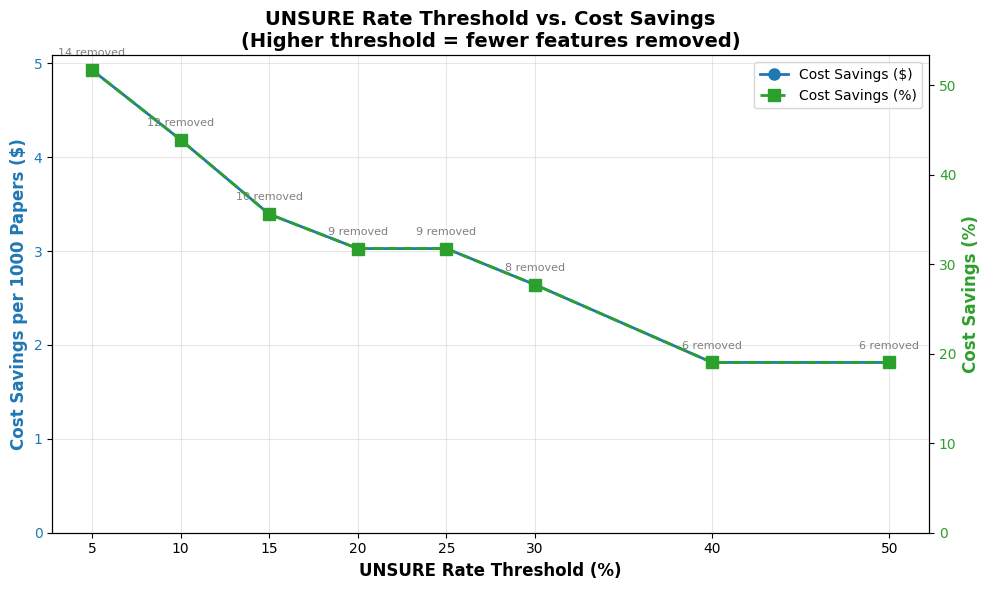


Summary Table:


,Threshold (%),Features Removed,Features Remaining,Cost per 1000 ($),Savings ($),Savings (%)
0,5.0,14,15,4.60,4.93,51.72
1,10.0,12,17,5.34,4.19,43.92
2,15.0,10,19,6.14,3.39,35.61
3,20.0,9,20,6.50,3.03,31.76
4,25.0,9,20,6.50,3.03,31.76
5,30.0,8,21,6.89,2.64,27.73
6,40.0,6,23,7.72,1.81,19.03
7,50.0,6,23,7.72,1.81,19.03


In [79]:
# Create the plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot cost savings (left y-axis)
color1 = "tab:blue"
ax1.set_xlabel("UNSURE Rate Threshold (%)", fontsize=12, fontweight="bold")
ax1.set_ylabel("Cost Savings per 1000 Papers ($)", color=color1, fontsize=12, fontweight="bold")
line1 = ax1.plot(
    results_df["threshold_pct"], results_df["cost_savings"], marker="o", color=color1, linewidth=2, markersize=8, label="Cost Savings ($)"
)
ax1.tick_params(axis="y", labelcolor=color1)
ax1.set_ylim(bottom=0)

# Add cost savings percentage as secondary y-axis
ax2 = ax1.twinx()
color2 = "tab:green"
ax2.set_ylabel("Cost Savings (%)", color=color2, fontsize=12, fontweight="bold")
line2 = ax2.plot(
    results_df["threshold_pct"],
    results_df["cost_savings_pct"],
    marker="s",
    color=color2,
    linewidth=2,
    markersize=8,
    linestyle="--",
    label="Cost Savings (%)",
)
ax2.tick_params(axis="y", labelcolor=color2)
ax2.set_ylim(bottom=0)

# Add number of features removed as annotations
for i, row in results_df.iterrows():
    ax1.annotate(
        f"{int(row['features_removed'])} removed",
        (row["threshold_pct"], row["cost_savings"]),
        textcoords="offset points",
        xytext=(0, 10),
        ha="center",
        fontsize=8,
        color="gray",
    )

# Combine legends
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc="upper right")

ax1.set_title("UNSURE Rate Threshold vs. Cost Savings\n(Higher threshold = fewer features removed)", fontsize=14, fontweight="bold")
ax1.grid(True, alpha=0.3)
ax1.set_xticks(results_df["threshold_pct"])

plt.tight_layout()
plt.show()

# Display summary table
print("\nSummary Table:")
display(
    results_df[["threshold_pct", "features_removed", "features_remaining", "cost_per_1000", "cost_savings", "cost_savings_pct"]]
    .round(2)
    .rename(
        columns={
            "threshold_pct": "Threshold (%)",
            "features_removed": "Features Removed",
            "features_remaining": "Features Remaining",
            "cost_per_1000": "Cost per 1000 ($)",
            "cost_savings": "Savings ($)",
            "cost_savings_pct": "Savings (%)",
        }
    )
)

# Strategies to Improve Recall

## 1. Remove Contradictory Observations
Papers with identical features but different labels add noise to training.

In [164]:
# Check for contradictory observations (identical features, different labels)
def resolve_conflicts(df_input, strategy="majority"):
    """
    Handle papers with identical features but different labels.

    Args:
        df_input: DataFrame with features and 'label' column
        strategy: 'remove' (drop all conflicts) or 'majority' (keep majority label)

    Returns:
        Cleaned DataFrame
    """
    feature_cols = [col for col in df_input.columns if col.startswith("I") or col.startswith("E")]

    if strategy == "remove":
        # Remove all papers with conflicting labels
        df_clean = df_input.groupby(feature_cols).filter(lambda x: x["label"].nunique() == 1)
    elif strategy == "majority":
        # Compute majority label per feature pattern avoiding groupby.apply on grouping columns
        def majority_label(series):
            counts = series.value_counts()
            if len(counts) == 1:
                return counts.index[0]
            # If tie, prefer True (to favor recall)
            if counts.iloc[0] == counts.iloc[1]:
                return True
            return counts.idxmax()

        maj = df_input.groupby(feature_cols, as_index=False)["label"].agg(majority_label).rename(columns={"label": "majority_label"})

        # Merge majority label back and keep only rows matching it
        df_merged = df_input.merge(maj, on=feature_cols, how="left")
        df_clean = df_merged[df_merged["label"] == df_merged["majority_label"]].drop(columns=["majority_label"])
    else:
        raise ValueError(f"Unknown strategy: {strategy}")

    return df_clean.reset_index(drop=True)


# Analyze conflicts
duplicates_check = df_temp.groupby(features_cols).filter(lambda x: len(x) > 1 and x["label"].nunique() > 1)

print(f"Dataset Analysis:")
print(f"Total papers: {len(df_temp)}")
print(f"Contradictory papers: {len(duplicates_check)} ({len(duplicates_check)/len(df_temp)*100:.1f}%)")
print(f"Unique feature patterns with conflicts: {duplicates_check.groupby(features_cols).ngroups}")
print(f"\nClass distribution:")
print(f"  Included: {df_temp['label'].sum()} ({df_temp['label'].sum()/len(df_temp)*100:.1f}%)")
print(f"  Excluded: {(~df_temp['label']).sum()} ({(~df_temp['label']).sum()/len(df_temp)*100:.1f}%)")

Dataset Analysis:
Total papers: 5747
Contradictory papers: 1489 (25.9%)
Unique feature patterns with conflicts: 54

Class distribution:
  Included: 532 (9.3%)
  Excluded: 5215 (90.7%)


In [165]:
# Compare strategies
df_removed = resolve_conflicts(df_temp, strategy="remove")
df_majority = resolve_conflicts(df_temp, strategy="majority")

print("Strategy Comparison:")
print(f"\nOriginal: {len(df_temp)} papers, {df_temp['label'].sum()} included")
print(f"\nRemove All Conflicts: {len(df_removed)} papers, {df_removed['label'].sum()} included")
print(f"  → Removed: {len(df_temp) - len(df_removed)} papers")
print(f"  → Class balance: {df_removed['label'].sum()/len(df_removed)*100:.1f}% included")
print(f"\nKeep Majority Label: {len(df_majority)} papers, {df_majority['label'].sum()} included")
print(f"  → Removed: {len(df_temp) - len(df_majority)} papers")
print(f"  → Class balance: {df_majority['label'].sum()/len(df_majority)*100:.1f}% included")
print("\nRecommendation: Use 'majority' strategy - removes only severely conflicting papers")

Strategy Comparison:

Original: 5747 papers, 532 included

Remove All Conflicts: 4258 papers, 222 included
  → Removed: 1489 papers
  → Class balance: 5.2% included

Keep Majority Label: 5633 papers, 500 included
  → Removed: 114 papers
  → Class balance: 8.9% included

Recommendation: Use 'majority' strategy - removes only severely conflicting papers


## 2. SMOTE (Synthetic Minority Over-sampling Technique)
Handle class imbalance by generating synthetic included papers.

Source: https://www.geeksforgeeks.org/machine-learning/ml-handling-imbalanced-data-with-smote-and-near-miss-algorithm-in-python/

In [166]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Use the ORIGINAL dataset (with conflicts) for splitting
# This ensures test set contains conflicting rows for realistic evaluation
X_original = df_temp[features_cols]
y_original = df_temp["label"]

# Split ORIGINAL data first - test set will contain conflicts
X_train_orig, X_temp_orig, y_train_orig, y_temp_orig = train_test_split(
    X_original, y_original, test_size=0.4, random_state=RANDOM_STATE, stratify=y_original
)
X_val_orig, X_test_orig, y_val_orig, y_test_orig = train_test_split(
    X_temp_orig, y_temp_orig, test_size=0.5, random_state=RANDOM_STATE, stratify=y_temp_orig
)

# Combine train + val for final training
X_train_full_orig = pd.concat([X_train_orig, X_val_orig])
y_train_full_orig = pd.concat([y_train_orig, y_val_orig])

print(f"Original dataset splits (test contains conflicts):")
print(f"  Train: {len(X_train_full_orig)} papers, {y_train_full_orig.sum()} included ({y_train_full_orig.sum()/len(X_train_full_orig)*100:.1f}%)")
print(f"  Test: {len(X_test_orig)} papers, {y_test_orig.sum()} included ({y_test_orig.sum()/len(X_test_orig)*100:.1f}%)")

# Now clean ONLY the training data using majority strategy
train_df = pd.DataFrame(X_train_full_orig)
train_df["label"] = y_train_full_orig.values
train_df_clean = resolve_conflicts(train_df, strategy="majority")

X_train_clean = train_df_clean[features_cols]
y_train_clean = train_df_clean["label"]

print(f"\nAfter cleaning ONLY training data:")
print(f"  Train (clean): {len(X_train_clean)} papers, {y_train_clean.sum()} included ({y_train_clean.sum()/len(X_train_clean)*100:.1f}%)")
print(f"  Removed from train: {len(X_train_full_orig) - len(X_train_clean)} conflicting papers")

# Train with SMOTE on cleaned training data
print("\nApplying SMOTE to cleaned training data...")
smote = SMOTE(random_state=RANDOM_STATE, k_neighbors=3)
X_train_smote, y_train_smote = smote.fit_resample(X_train_clean, y_train_clean)

print(f"After SMOTE:")
print(f"  Train: {len(X_train_smote)} papers, {y_train_smote.sum()} included ({y_train_smote.sum()/len(y_train_smote)*100:.1f}%)")

# Train RF on SMOTE data
rf_smote = RandomForestClassifier(**best_rf_rnd.get_params())
rf_smote.fit(X_train_smote, y_train_smote)

# Predict on ORIGINAL test set (with conflicts!)
y_test_proba_smote = rf_smote.predict_proba(X_test_orig)[:, 1]

# Find best threshold for 95%+ recall
recall_results_smote = []
for thresh in np.arange(0.05, 0.55, 0.05):
    y_pred_thresh = (y_test_proba_smote >= thresh).astype(int)
    recall_results_smote.append(
        {
            "threshold": thresh,
            "recall": recall_score(y_test_orig, y_pred_thresh),
            "precision": precision_score(y_test_orig, y_pred_thresh),
            "accuracy": accuracy_score(y_test_orig, y_pred_thresh),
            "specificity": specificity_score(y_test_orig, y_pred_thresh),
        }
    )

recall_df_smote = pd.DataFrame(recall_results_smote)
best_thresh_smote = (
    recall_df_smote[recall_df_smote["recall"] >= 0.95].iloc[-1] if (recall_df_smote["recall"] >= 0.95).any() else recall_df_smote.iloc[-1]
)

print(f"\nSMOTE + Clean Training Data Results (test with conflicts):")
print(f"Best threshold: {best_thresh_smote['threshold']:.2f}")
print(f"  Recall: {best_thresh_smote['recall']:.2f}")
print(f"  Precision: {best_thresh_smote['precision']:.2f}")
print(f"  Accuracy: {best_thresh_smote['accuracy']:.2f}")
print(f"  Specificity: {best_thresh_smote['specificity']:.2f}")

Original dataset splits (test contains conflicts):
  Train: 4597 papers, 425 included (9.2%)
  Test: 1150 papers, 107 included (9.3%)

After cleaning ONLY training data:
  Train (clean): 4502 papers, 403 included (9.0%)
  Removed from train: 95 conflicting papers

Applying SMOTE to cleaned training data...
After SMOTE:
  Train: 8198 papers, 4099 included (50.0%)

SMOTE + Clean Training Data Results (test with conflicts):
Best threshold: 0.35
  Recall: 0.95
  Precision: 0.65
  Accuracy: 0.95
  Specificity: 0.95


## 4. Comparison of All Approaches

In [181]:
# Compare all approaches
comparison_all = pd.DataFrame(
    [
        {
            "Approach": "Original (Baseline)",
            "Dataset": f"{len(df_temp)} papers",
            "Features": len(features_cols),
            "Recall": final_recall,
            "Precision": final_precision,
            "Specificity": final_specificity,
            "Accuracy": final_accuracy,
            "Threshold": best_threshold_95,
        },
        {
            "Approach": "Filtered (no SMOTE)",
            "Dataset": f"{len(df_temp)} papers",
            "Features": len(features_filtered),
            "Recall": final_recall_f,
            "Precision": final_precision_f,
            "Specificity": final_specificity_f,
            "Accuracy": final_accuracy_f,
            "Threshold": best_threshold_f,
        },
        {
            "Approach": "Clean Train + SMOTE",
            "Dataset": f"Train: {len(X_train_clean)}, Test: {len(X_test_orig)} (with conflicts)",
            "Features": len(features_cols),
            "Recall": best_thresh_smote["recall"],
            "Precision": best_thresh_smote["precision"],
            "Specificity": best_thresh_smote["specificity"],
            "Accuracy": best_thresh_smote["accuracy"],
            "Threshold": best_thresh_smote["threshold"],
        },
    ]
)


print("FINAL COMPARISON - ALL APPROACHES")
print("(Note: SMOTE approaches clean only training data; test set contains conflicts)")
display(comparison_all.round(3))

# Calculate improvement
recall_improvement = (comparison_all.iloc[2]["Recall"] - comparison_all.iloc[0]["Recall"]) * 100
print(f"\nRecall Improvement (SMOTE vs Baseline): {recall_improvement:+.1f} percentage points")
print(
    f"Missed Papers Reduction: {int((1 - comparison_all.iloc[0]['Recall']) * y_test.sum())} → {int((1 - comparison_all.iloc[2]['Recall']) * y_test_orig.sum())}"
)

FINAL COMPARISON - ALL APPROACHES
(Note: SMOTE approaches clean only training data; test set contains conflicts)


,Approach,Dataset,Features,Recall,Precision,Specificity,Accuracy,Threshold
0,Original (Baseline),5747 papers,29,0.915,0.606,0.940,0.937,0.50
1,Filtered (no SMOTE),5747 papers,19,0.915,0.602,0.939,0.937,0.50
2,Clean Train + SMOTE,"Train: 4502, Test: 1150 (with conflicts)",29,0.953,0.646,0.946,0.947,0.35



Recall Improvement (SMOTE vs Baseline): +3.8 percentage points
Missed Papers Reduction: 8 → 5
